In [1]:
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import math
from cnn_utils import *

np.random.seed(1)

/home/cb/.conda/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


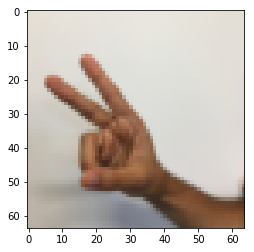

In [3]:
index = 6
plt.imshow(X_train_orig[index])
print('y = ' + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
Y_train_orig.shape

(1, 1080)

In [5]:
X_train_orig.shape

(1080, 64, 64, 3)

In [6]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print('number of training examples = ' + str(X_train.shape[0]))
print('numbet of test examples = ' + str(X_test.shape[0]))
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
numbet of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [7]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    return X,Y

In [8]:
X, Y = create_placeholders(64, 64, 3, 6)
print('X = ' + str(X))
print('Y = ' + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [9]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable('W1', [4,4,3,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable('W2', [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {'W1': W1, 'W2': W2}
    
    return parameters

### Forward propagation
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

In [10]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides=[1,8,8,1],padding='SAME')
    
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1],padding='SAME')
    
    P2 = tf.contrib.layers.flatten(P2)
    
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
    
    return Z3

In [11]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost

In [14]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009, num_epoches=100, minibatch_size=64, print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X ,Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epoches):
            minibatch_cost = 0
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, temp_cost = sess.run([optimizer,cost],feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost/num_minibatches
                
            if print_cost == True and epoch%5 == 0:
                print('Cost after epoch %i: %f' % (epoch, minibatch_cost))
            if print_cost == True and epoch%1 == 0:
                costs.append(minibatch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title('Learning rate =' + str(learning_rate))
        plt.show()
        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print('Train Accuracy: ', train_accuracy)
        print('Test Accuracy: ', test_accuracy)
        
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156
Cost after epoch 10: 1.904309
Cost after epoch 15: 1.904477
Cost after epoch 20: 1.901876
Cost after epoch 25: 1.784078
Cost after epoch 30: 1.681052
Cost after epoch 35: 1.618207
Cost after epoch 40: 1.597972
Cost after epoch 45: 1.566707
Cost after epoch 50: 1.554486
Cost after epoch 55: 1.502187
Cost after epoch 60: 1.461035
Cost after epoch 65: 1.304477
Cost after epoch 70: 1.201501
Cost after epoch 75: 1.144229
Cost after epoch 80: 1.098368
Cost after epoch 85: 1.077411
Cost after epoch 90: 1.043173
Cost after epoch 95: 1.022620
Cost after epoch 100: 1.013470
Cost after epoch 105: 0.962533
Cost after epoch 110: 0.961424
Cost after epoch 115: 0.929818
Cost after epoch 120: 0.931082
Cost after epoch 125: 0.891719
Cost after epoch 130: 0.900744
Cost after epoch 135: 0.860303
Cost after epoch 140: 0.888700
Cost after epoch 145: 0.833127
Cost after epoch 150: 0.862938
Cost after epoch 155: 0.804592
Cost after epoch 160: 0.795786

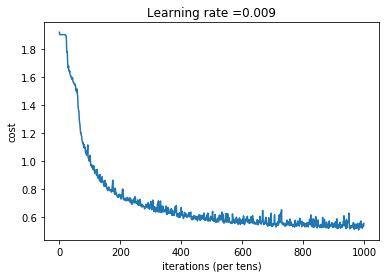

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy:  0.82685184
Test Accuracy:  0.65833336


In [15]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [16]:
tf.version

AttributeError: module 'tensorflow' has no attribute 'version'

In [17]:
tf.__path__

['/home/cb/.conda/envs/tensorflow/lib/python3.6/site-packages/tensorflow']

In [18]:
tf.__version__

'1.6.0'